In [0]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

--2019-10-19 17:17:09--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  33.6MB/s    in 10s     

2019-10-19 17:17:20 (32.4 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [0]:
!unzip cell_images.zip

Archive:  cell_images.zip
   creating: cell_images/
   creating: cell_images/Parasitized/
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_201509

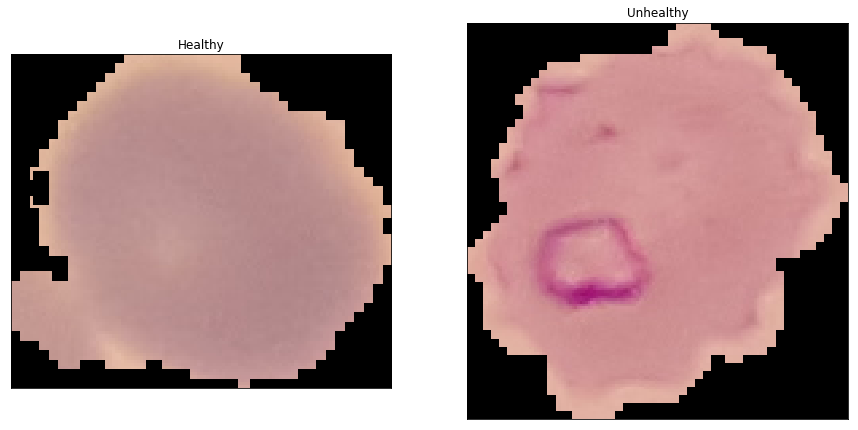

In [0]:
# Lots of help for this project from https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch/
# And https://www.kaggle.com/devilsknight/malaria-detection-with-pytorch

import numpy as np
import pandas as pd
import os
import PIL
import torch
import torchvision
from matplotlib.pyplot import *
import skimage.io

root_path = "/content/cell_images"
uninfected_cell_images = os.listdir(root_path + "/Uninfected")
infected_cell_images = os.listdir(root_path + "/Parasitized")
healthy_im = skimage.io.imread(os.path.join(root_path, "Uninfected", uninfected_cell_images[0]))
unhealthy_im = skimage.io.imread(os.path.join(root_path, "Parasitized", infected_cell_images[0]))

figure(figsize=(15, 10))

subplot(1, 2, 1)
title("Healthy")
imshow(healthy_im)
xticks([]);yticks([]);

subplot(1, 2, 2)
title("Unhealthy")
imshow(unhealthy_im)
xticks([]);yticks([]);

Text(0.5, 1.0, 'Image size and shape distribution.')

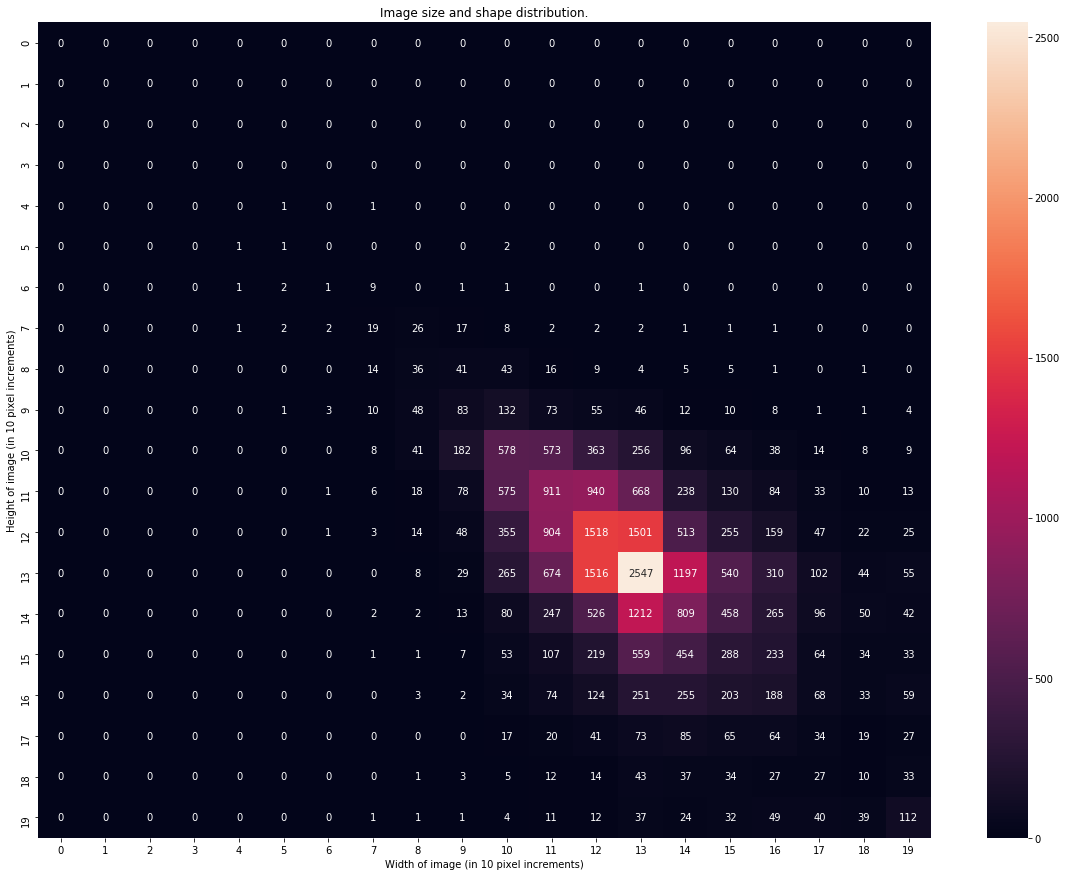

In [0]:
import seaborn as sn

# Create a table showing the distribution of image shapes / sizes.

sizes = np.zeros((20, 20), dtype=np.dtype(int))
for healthy_im_fname in uninfected_cell_images:
    if healthy_im_fname.endswith(".png"):
        w, h = PIL.Image.open(os.path.join(root_path, "Uninfected", healthy_im_fname)).size
        w = min(190, w)
        h = min(190, h)
        sizes[w // 10, h // 10] += 1

for sick_im_fname in infected_cell_images:
    if sick_im_fname.endswith(".png"):
        w, h = PIL.Image.open(os.path.join(root_path, "Parasitized", sick_im_fname)).size
        w = min(190, w)
        h = min(190, h)
        sizes[w // 10, h // 10] += 1

figure(figsize=(20,15))
df = pd.DataFrame(sizes)
sn.heatmap(df, fmt='d', annot=True)
xlabel("Width of image (in 10 pixel increments)")
ylabel("Height of image (in 10 pixel increments)")
title("Image size and shape distribution.")



All of the images are different sizes, so whatever we use will have to be robust enough to handle it.

In [0]:
# We need to create the Dataset
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random

# Define our data transforms
data_transforms = {
    'test': transforms.Compose([transforms.Resize((64, 64)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(5),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'train': transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

# Originally I had a custom dataset but I found ImageFolder to produce better results quicker. May have just been an error with my code.
train_set = torchvision.datasets.ImageFolder(root_path, transform=data_transforms['train'])
test_set = torchvision.datasets.ImageFolder(root_path, transform=data_transforms['test'])

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

valid_size = 0.2 # 20% of images used for validation
test_size = 0.1 # 10% of images used for testing.

start_valid = int(num_train - (num_train * valid_size + test_size))
start_test = int(num_train - (num_train * test_size))

# Samplers
train_sampler = SubsetRandomSampler(indices[0:start_valid])
val_sampler = SubsetRandomSampler(indices[start_valid:start_test])
test_sampler = SubsetRandomSampler(indices[start_test:])

In [0]:
def togpu(x):
    return x.cuda()
def tocpu(x):
    return x.cpu()

In [0]:
from torch.autograd import Variable
import torch.nn.functional as F

# Now we get to the CNN
class MalariaCNN(torch.nn.Module):
    
    def __init__(self):
        super(MalariaCNN, self).__init__()
        
        # The shape of the images are 64 x 64 x 3
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # After pooling the images should be 16 x 16
        self.fc1 = torch.nn.Linear(in_features=(64 * 16 * 16), out_features=1024)
        self.fc2 = torch.nn.Linear(in_features=1024, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
        
    def forward(self, x):
        
        # Size changes from (3, 64, 64) to (64, 64, 64)
        x = F.relu(self.conv1(x))
        
        # (64, 64, 64) -> (64, 32, 32)
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        
        # (64, 32, 32) -> (64, 16, 16)
        x = F.max_pool2d(x, 2)
        
        x = x.reshape(-1, 64 * 16 * 16)
        
        # 16384 -> 1024
        x = F.relu(self.fc1(x))
        
        # 1024 -> 64
        x = F.relu(self.fc2(x))
        
        # 64 -> 2
        x = self.fc3(x)
        
        return x

In [0]:

#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    
    return train_loader

test_loader = DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)
val_loader = DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

In [0]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    loss = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [0]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    training_start_time = time.time()
    
    min_val_loss = 1.0
    
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 5 # Print 10 times total each epoch
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data
            
            #print(inputs, labels)
            inputs, labels = Variable(togpu(inputs)), Variable(togpu(labels))
            
            optimizer.zero_grad()
    
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            # print(loss_size.data.item())
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            
            if i % print_every == print_every - 1:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch+1, int(100 * (i + 1) / n_batches), running_loss / print_every, time.time() - start_time
                ))
                
                running_loss = 0.0
                start_time = time.time()
                
        total_val_loss = 0
        for inputs, labels in val_loader:
            inputs, labels = Variable(togpu(inputs)), Variable(togpu(labels))
            
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data.item()
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        if (total_val_loss / len(val_loader)) < min_val_loss:
            print("New best: ({} -> {})".format(min_val_loss, total_val_loss / len(val_loader)))
            min_val_loss = total_val_loss / len(val_loader)
            torch.save(net.state_dict(), "malaria_best.pt")
                                
        
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    

In [0]:
CNN = togpu(MalariaCNN())
trainNet(CNN, batch_size=64, n_epochs=25, learning_rate=0.002)

===== HYPERPARAMETERS =====
batch_size= 64
epochs= 25
learning_rate= 0.002
Epoch 1, 20% 	 train_loss: 0.65 took: 5.76s
Epoch 1, 40% 	 train_loss: 0.25 took: 5.57s
Epoch 1, 60% 	 train_loss: 0.24 took: 5.48s
Epoch 1, 80% 	 train_loss: 0.21 took: 5.45s
Epoch 1, 100% 	 train_loss: 0.19 took: 5.43s
Validation loss = 0.18
New best: (1.0 -> 0.1758107194169001)
Epoch 2, 20% 	 train_loss: 0.17 took: 5.67s
Epoch 2, 40% 	 train_loss: 0.18 took: 5.52s
Epoch 2, 60% 	 train_loss: 0.15 took: 5.48s
Epoch 2, 80% 	 train_loss: 0.15 took: 5.53s
Epoch 2, 100% 	 train_loss: 0.16 took: 5.37s
Validation loss = 0.16
New best: (0.1758107194169001 -> 0.15980503877455537)
Epoch 3, 20% 	 train_loss: 0.15 took: 5.64s
Epoch 3, 40% 	 train_loss: 0.14 took: 5.57s
Epoch 3, 60% 	 train_loss: 0.15 took: 5.57s


Got 0/1 correct


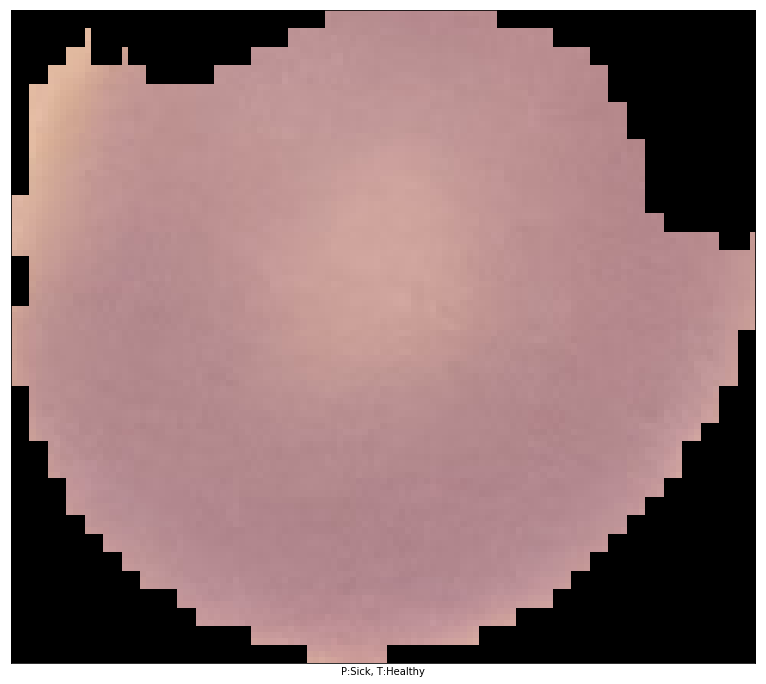

In [0]:
def getPrediction(net, image_path):
    # Helper function that returns the output of the network.
    # In this case, it will return a 1 if the cell is parasite-free.
    image = PIL.Image.open(image_path)
    prediction_transform = transforms.Compose([
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])

    image = prediction_transform(image).unsqueeze(0)

    net = net.cpu()
    net.eval()
    idx = torch.argmax(net(image))

    return idx

# Load the best state of the CNN
CNN.load_state_dict(torch.load('malaria_best.pt'))

# Draw 100 cells along with their predicted and target values.
figure(figsize=(25,12))
num_predictions = 1
correct_predictions = 0
ncols = int(num_predictions ** 0.5)
nrows = int(num_predictions / ncols)
for i in range(num_predictions):
    sub_path = 'upload'
    images_path = os.path.join(root_path, sub_path)
    final_path = os.path.join(images_path, random.choice([fname for fname in os.listdir(images_path) if fname.endswith(".png")]))
    prediction = "Sick" if getPrediction(CNN, final_path) == 0 else "Healthy"
    target = "Sick" if sub_path == "Parasitized" else "Healthy"
    correct_predictions += 1 if target == prediction else 0
    subplot(nrows, ncols, i+1)
    imshow(PIL.Image.open(final_path))
    xticks([]);yticks([]);
    xlabel("P:{}, T:{}".format(prediction, target))

print("Got {}/{} correct".format(correct_predictions, num_predictions))

In [0]:
pip install anvil-uplink

     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for ws4py: filename=ws4py-0.3.4-cp36-none-any.whl size=41809 sha256=88fe6d1f76984f13fd485268d357e54526a3f3b45ac819e21a065405fb65aaca
  Stored in directory: /root/.cache/pip/wheels/19/1f/0d/beff5822af761b66067b5e0b251a9c66af3ae15828ee9a8f15
Successfully built ws4py


In [0]:


import anvil.server
anvil.server.connect('ZDE4BVXBH6MECAZKXQXCENFM-MY6ODHGTFVIAC5GR')
import anvil.media
import socket
import io
import os
from random import randint
from PIL import Image


@anvil.server.callable
def classify_image(file):
    rand = random.Random()
    
    with anvil.media.TempFile(file) as filename:
      img = Image.open(io.BytesIO(file.get_bytes()))
      bs = io.BytesIO()
      #img.save(bs, format="JPEG")
      # save image in upload 
      img.save('/content/cell_images/upload/myphoto.png', 'PNG')
      final_path = '/content/cell_images/upload/myphoto.png'
      prediction = "Sick" if getPrediction(CNN, final_path) == 0 else "Healthy"
      # save image for backup      
      lol = str(randint(1,1000000))
      backup_path = "/content/cell_images/backup/"+lol+".png"
      img.save(backup_path, 'JPEG')
      return(prediction)
try:
  os.remove('/content/cell_images/upload/myphoto.png')
except:
  pass
